# Template Molecule-based Masking

This uses the "Cube Reprojection and Signal Masking Tutorial" (public version available [here](https://gist.github.com/abulatek/cc1cd9e62a04c7b5487f3a45d9633823)) written by Adam Ginsburg, Eric Koch, Tom Robitaille, and Erik Rosolowsky and adapted by Alyssa Bulatek. It uses an H2CS cube to create a signal mask for a rung of a CH3CN ladder (which has a more complicated velocity structure), putting both cubes on the same velocity grid in the process.

We will go through this process for one of the k-components of the methyl cyanide cube, creating functions along the way, and then repeat for each of the other k-components in a loop.

This needs to be run on a 20 GB computing node to get through all rungs. 16 GB is not enough (it only gets through 6 or so).

## Navigation

1. [Access the data](#1.-Access-the-data)
2. [Find lines in cubes](#2.-Find-lines-in-cubes)
3. [Convert cube spectral axes from frequency to velocity](#3.-Convert-cube-spectral-axes-from-frequency-to-velocity)
4. [Spectral Interpolation](#4.-Spectral-Interpolation)
5. [Spatial Smoothing](#5.-Spatial-Smoothing)
6. [Reprojection](#6.-Reprojection)
7. [Signal Masking](#7.-Signal-Masking)
8. [Moment Maps](#8.-Moment-Maps)
9. [Masking Outliers](#9.-Masking-Outliers)
10. [Export Masked Cubes](#10.-Export-Masked-Cubes)

In [1]:
import time
start = time.time()

import pylab as pl
display_dpi = 150

## 1. Access the data

In [2]:
# %matplotlib inline
from spectral_cube import SpectralCube
from astropy import units as u
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'

First, we'll get the template molecule cube (H2CS).

In [3]:
# Get H2CS (template molecule) cube
freq_spw = '135_spw47'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
h2cscube = SpectralCube.read(fn, format='casa_image')
h2cscube

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


DaskVaryingResolutionSpectralCube with shape=(3840, 512, 512) and unit=Jy / beam and chunk size (128, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 133582251086.390 Hz:135456817280.560 Hz

Then, we'll get the target molecule cube (CH3CN).

In [4]:
# Get methyl cyanide (target molecule) cube
freq_spw = '146_spw51'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
ch3cncube = SpectralCube.read(fn, format='casa_image')
ch3cncube

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


DaskVaryingResolutionSpectralCube with shape=(3840, 512, 512) and unit=Jy / beam and chunk size (128, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 145582599820.702 Hz:147457166014.871 Hz

## 2. Find lines in cubes
We'll use Splatalogue to list the lines within the frequency ranges of each cube to confirm that we're covering the lines we want to cover.

In [5]:
from astroquery.splatalogue import Splatalogue
h2cscube.find_lines(chemical_name='H2CS', line_lists=['JPL'], 
                    show_upper_degeneracy=True).show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
0,H2CS,Thioformaldehyde,--,--,135.297811,0.00025,"4(1,4)-3(1,3)",-3.2444,30.5155,11.222,-4.48704,0.64,15.937,22.92966,20.45005,29.42289,27.0,JPL


In [6]:
ch3cntbl = ch3cncube.find_lines(chemical_name='CH3CN', line_lists=['JPL'], 
                                show_upper_degeneracy=True, show_qn_code=True)
ch3cntbl = ch3cntbl[ch3cntbl['Quantum Number Code'] == 202]
ch3cntbl = ch3cntbl[::-1]
ch3cn_freqs = ch3cntbl['Freq-GHz(rest frame,redshifted)']
ch3cntbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Quantum Number Code,Linelist
0,CH3CNv=0,Methyl Cyanide,147.1745883,2e-07,--,--,8(0)-7(0),-2.6575,169.60673,11.02642,-3.7326,--,17.1828,24.72238,22.09202,31.78569,34.0,202,JPL
1,CH3CNv=0,Methyl Cyanide,147.1717519,2e-07,--,--,8(1)-7(1),-2.6748,166.91824,10.85164,-3.73957,--,22.1491,31.86782,27.05822,38.931,34.0,202,JPL
2,CH3CNv=0,Methyl Cyanide,147.1632441,2e-07,--,--,8(2)-7(2),-2.727,158.99516,10.33654,-3.76076,--,37.047,53.30272,41.95584,60.36548,34.0,202,JPL
3,CH3CNv=0,Methyl Cyanide,147.1490683,1e-07,--,--,8(3)-7(3),-2.5156,291.45821,18.94819,-3.79873,--,61.8731,89.02217,66.78146,96.08426,68.0,202,JPL
4,CH3CNv=0,Methyl Cyanide,147.1292302,1e-07,--,--,8(4)-7(4),-2.9482,127.19471,8.26914,-3.85798,--,96.6217,139.01798,101.5294,146.07911,34.0,202,JPL
5,CH3CNv=0,Methyl Cyanide,147.103738,1e-07,--,--,8(5)-7(5),-3.1316,103.33459,6.71796,-3.94843,--,141.2849,203.27878,146.19175,210.33869,34.0,202,JPL
6,CH3CNv=0,Methyl Cyanide,147.0726021,1e-07,--,--,8(6)-7(6),-3.0883,148.38336,9.64665,-4.09259,--,195.8526,281.79004,200.75841,288.84846,68.0,202,JPL
7,CH3CNv=0,Methyl Cyanide,147.0358351,1e-07,--,--,8(7)-7(7),-3.7949,39.74307,2.58376,-4.36401,--,260.3123,374.53377,265.21689,381.59042,34.0,202,JPL


## 3. Convert cube spectral axes from frequency to velocity
Here, we convert the spectral axis of each cube from frequency to velocity, using the rest frequency of each line (which we can see in the step above) to do the conversion.

In [7]:
h2cscube = h2cscube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                       rest_value=135.297811*u.GHz).spectral_slab(-10*u.km/u.s, 
                                                                                  80*u.km/u.s)
print(h2cscube)
h2cssubcube = h2cscube.spectral_slab(-10*u.km/u.s, 30*u.km/u.s)

DaskVaryingResolutionSpectralCube with shape=(85, 512, 512) and unit=Jy / beam and chunk size (68, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     85  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      80.460 km / s


In [8]:
def get_targetcube(comp):
    targetcube = ch3cncube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                             rest_value=ch3cn_freqs[comp]*u.GHz).spectral_slab(-10*u.km/u.s,
                                                                                               80*u.km/u.s)
    print(targetcube)
    targetsubcube = targetcube.spectral_slab(-10*u.km/u.s, 30*u.km/u.s)
    return targetcube, targetsubcube

In [9]:
targetcube, targetsubcube = get_targetcube(0)

DaskVaryingResolutionSpectralCube with shape=(91, 512, 512) and unit=Jy / beam and chunk size (71, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:       -9.650 km / s:      79.868 km / s


### *REMEMBER TO DO THE SAME FOR THE HIGH-VELOCITY COMPONENTS!*

### 3.1. Do some quicklooks of the peak intensity to see what we expect to see

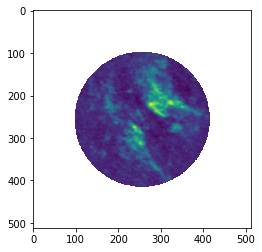

In [10]:
h2cssubcube.max(axis=0).quicklook()
# This first quicklook has to be re-run, as it doesn't run the first time (not sure why)

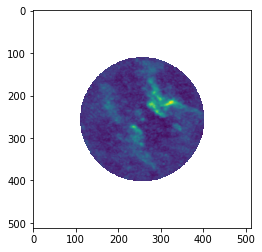

In [11]:
targetsubcube.max(axis=0).quicklook()

# *****Converting cubes from Jy/beam to K*****
***This is a very important step. It used to take a long time to run with an old version of*** `spectral-cube`***.***

In [12]:
h2cssubcube = h2cssubcube.to(u.K)
targetsubcube = targetsubcube.to(u.K)

## 4. Spectral Interpolation
First of all, we need to convert these cubes from `VaryingResolutionSpectralCubes` to `SpectralCubes`. First, we'll compare the beam sizes of the cubes.

In [13]:
h2cssubcube.beams, targetsubcube.beams

(<Beams [5.54782914e-11, 5.54786541e-11, 5.54790393e-11, 5.54794101e-11,
         5.54797749e-11, 5.54801437e-11, 5.54804993e-11, 5.54808641e-11,
         5.54812227e-11, 5.54815853e-11, 5.54819695e-11, 5.54823343e-11,
         5.54827113e-11, 5.54830658e-11, 5.54834461e-11, 5.54838098e-11,
         5.54841798e-11, 5.54845547e-11, 5.54849266e-11, 5.54852862e-11,
         5.54856530e-11, 5.54860146e-11, 5.54863998e-11, 5.54867451e-11,
         5.54871243e-11, 5.54874675e-11, 5.54878567e-11, 5.54882113e-11,
         5.54885853e-11, 5.54889633e-11, 5.54893137e-11, 5.54896959e-11,
         5.54900586e-11, 5.54904131e-11, 5.54907831e-11, 5.54911520e-11,
         5.54915250e-11, 5.54918918e-11] sr>,
 <Beams [4.77419483e-11, 4.77416592e-11, 4.77413732e-11, 4.77410841e-11,
         4.77407998e-11, 4.77405117e-11, 4.77402069e-11, 4.77399284e-11,
         4.77396318e-11, 4.77393506e-11, 4.77390635e-11, 4.77387792e-11,
         4.77384960e-11, 4.77381966e-11, 4.77379229e-11, 4.77376342e-11,
     

Now, we'll smooth each cube to the common beam for that cube.

In [14]:
h2cssubcube_common_beam = h2cssubcube.beams.common_beam()
h2cssubcube_b = h2cssubcube.convolve_to(h2cssubcube_common_beam)
targetsubcube_common_beam = targetsubcube.beams.common_beam()
targetsubcube_b = targetsubcube.convolve_to(targetsubcube_common_beam)
h2cssubcube_b.beam, targetsubcube_b.beam

(Beam: BMAJ=1.621724247932434 arcsec BMIN=1.2848083972930908 arcsec BPA=-84.60916900634766 deg,
 Beam: BMAJ=1.510909080505371 arcsec BMIN=1.1864451169967651 arcsec BPA=-81.83074951171875 deg)

Now, we must match the spectral resolution of the template and target cubes. To begin, we'll convert the spectral axis units back to km/s from m/s. The `b` stands for beam (since we're doing some beam smoothing).

In [15]:
# This might not be the neatest way to do this
h2cssubcube_b = h2cssubcube_b.with_spectral_unit(u.km/u.s)
targetsubcube_b = targetsubcube_b.with_spectral_unit(u.km/u.s)
h2cssubcube_b, targetsubcube_b

(DaskSpectralCube with shape=(38, 512, 512) and unit=K and chunk size (38, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     38  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      29.607 km / s,
 DaskSpectralCube with shape=(41, 512, 512) and unit=K and chunk size (41, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     41  type_s: VRAD      unit_s: km / s  range:       -9.650 km / s:      30.136 km / s)

We'll start by printing the spectral resolutions for each cube to compare them.

In [16]:
import numpy as np
velocity_res_1 = np.diff(h2cssubcube_b.spectral_axis)[0]
velocity_res_2 = np.diff(targetsubcube_b.spectral_axis)[0]
np.abs(velocity_res_1), np.abs(velocity_res_2)

(<Quantity 1.08196348 km / s>, <Quantity 0.99465058 km / s>)

Since the channel width of the H2CS (template) cube is larger, we'll smooth the resolution of the CH3CN (target) cube to the broader resolution. We will do this by smoothing with a Gaussian with an appropriate FWHM. *In the loop, we assume that the channel width of the H2CS (template) cube is always larger.*

In [17]:
fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2)**0.5
fwhm_gaussian

<Quantity 0.42581121 km / s>

In [18]:
from astropy.convolution import Gaussian1DKernel
fwhm_to_sigma = np.sqrt(8*np.log(2))
# We want the kernel in pixel units, so we force to km/s and take the value
spectral_smoothing_kernel = Gaussian1DKernel(stddev=fwhm_gaussian.to(u.km/u.s).value / fwhm_to_sigma)

Now, we will cut the cubes so they only cover a common velocity range (essentially cutting the larger cube down to the smaller cube, but this is a general way to do that in case they overlap incompletely). Since we're working with subcubes, the difference isn't too great (and we expect the boundaries after the cut to be not exactly the same between cubes, since the velocity grid is still different). The `c` stands for "cutout."

In [19]:
vel_lo = np.max([h2cssubcube_b.spectral_axis.min().value, 
                 targetsubcube_b.spectral_axis.min().value])*u.km/u.s
vel_hi = np.min([h2cssubcube_b.spectral_axis.max().value, 
                 targetsubcube_b.spectral_axis.max().value])*u.km/u.s

h2cssubcube_bc = h2cssubcube_b.spectral_slab(vel_lo, vel_hi)
targetsubcube_bc = targetsubcube_b.spectral_slab(vel_lo, vel_hi)
h2cssubcube_bc, targetsubcube_bc

(DaskSpectralCube with shape=(37, 512, 512) and unit=K and chunk size (37, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s,
 DaskSpectralCube with shape=(40, 512, 512) and unit=K and chunk size (40, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     40  type_s: VRAD      unit_s: km / s  range:       -9.650 km / s:      29.141 km / s)

We then smooth with the kernel.  Note that this is doing 512*512 = 262144 smoothing operations on a length-41 spectrum: it will take a little time. The `spec` stands for "spectral interpolation."

In [20]:
targetsubcube_bc_spec = targetsubcube_bc.spectral_smooth(spectral_smoothing_kernel)

Now that we've done spectral smoothing, we can resample the spectrum.

In [21]:
targetsubcube_bc_spec_resample = targetsubcube_bc_spec.spectral_interpolate(h2cssubcube_bc.spectral_axis)
targetsubcube_bc_spec_resample

DaskSpectralCube with shape=(37, 512, 512) and unit=K and chunk size (37, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s

## 5. Spatial Smoothing
Now that we've done spectral smoothing, we have to spatially smooth, because we'll resample the data spatially too. Finally, we'll convolve both cubes to a common beam that matches the larger beam size.

In [22]:
h2cssubcube_bc.beam, targetsubcube_bc_spec_resample.beam

(Beam: BMAJ=1.621724247932434 arcsec BMIN=1.2848083972930908 arcsec BPA=-84.60916900634766 deg,
 Beam: BMAJ=1.510909080505371 arcsec BMIN=1.1864451169967651 arcsec BPA=-81.83074951171875 deg)

The H2CS (template) cube has the larger beam, so we'll smooth the CH3CN (target) cube to its resolution. *In the loop, we assume that the H2CS (template) cube always has the larger beamsize.* First, calculate the common beam:

In [23]:
import radio_beam
common_beam = radio_beam.commonbeam.common_2beams(radio_beam.Beams(beams=[h2cssubcube_bc.beam, 
                                                                          targetsubcube_bc_spec_resample.beam]))
common_beam

Beam: BMAJ=1.621724247932434 arcsec BMIN=1.2848083972930908 arcsec BPA=-84.60916900634766 deg

Now, we'll convolve the CH3CN beam to match the larger H2CS beam. ***We'll convert to kelvin to ensure the units are preserved, though the conversion is already done earlier in the code.*** The `spat` stands for "spatial smoothing."

In [24]:
targetsubcube_bc_spec_resample_spat = targetsubcube_bc_spec_resample.to(u.K).convolve_to(common_beam)
targetsubcube_bc_spec_resample_spat
# This takes a long time, and has a new warning:
# WARNING: nan_treatment='interpolate', however, NaN values detected post convolution.
# A contiguous region of NaN values, larger than the kernel size, are present in the input array. 
# Increase the kernel size to avoid this. [astropy.convolution.convolve]

DaskSpectralCube with shape=(37, 512, 512) and unit=K and chunk size (37, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s

## 6. Reprojection
Now, we can reproject one cube onto the other.

In [25]:
import astropy
print(astropy.__version__)
import reproject
print(reproject.__version__)
import spectral_cube
print(spectral_cube.__version__)
import dask
print(dask.__version__)
# Need development version of astropy
# 4.3.dev1788+ga3263b6 works for me

# AG is: (on 2/10/2022)
#5.1.dev541+ged8cab8
#0.9.dev20+g41dbdf3
#0.6.1.dev38+g52cfdb9
#2021.10.0

4.3.dev2042+g5ec6b5c
0.8.dev31+g9f8ec7b
0.6.1.dev153+g7d0b9c7
2021.06.0


In [26]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [27]:
start2 = time.time()
targetsubcube_bc_reproj = targetsubcube_bc_spec_resample_spat.reproject(h2cssubcube_bc.header)
targetsubcube_bc_reproj
# This is currently taking a longgggg time to run, which is a sign that something went wrong?
end = time.time()
print(f"Time elapsed: {end - start2} seconds (total since start = {end - start} seconds)")

[                                        ] | 0% Completed |  0.1s

[                                        ] | 0% Completed |  4.6s

[                                        ] | 0% Completed |  9.5s

[                                        ] | 0% Completed | 38.6s

[########################################] | 100% Completed | 41.3s
Time elapsed: 75.78741645812988 seconds (total since start = 87.84772944450378 seconds)


These two cubes are now on an identical grid, and can be directly compared:

In [28]:
targetsubcube_bc_reproj, h2cssubcube_bc

(DaskSpectralCube with shape=(37, 512, 512) and unit=K and chunk size (37, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s,
 DaskSpectralCube with shape=(37, 512, 512) and unit=K and chunk size (37, 512, 512):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s)

These spectra can now be overplotted as they are in the same unit with the same beam.

[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


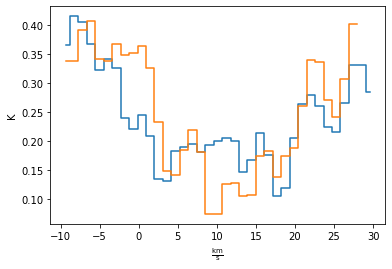

In [29]:
h2cssubcube_bc[:,256,256].to(u.K).with_spectral_unit(u.km/u.s).quicklook()
targetsubcube_bc_reproj[:,256,256].quicklook()

### Do a quick continuum subtraction
Since we're focusing on spectral line emission, we'll perform continuum subtraction on each cube, and rename the cubes while we're at it (the `f` stands for "final").

In [30]:
med1 = h2cssubcube_bc.median(axis=0)  
h2cssubcube_f = h2cssubcube_bc - med1
med2 = targetsubcube_bc_reproj.median(axis=0)  
targetsubcube_f_reproj = targetsubcube_bc_reproj - med2

[########################################] | 100% Completed |  4.5s
[####################                    ] | 50% Completed |  0.1s

[########################################] | 100% Completed |  1.6s


## 7. Signal Masking
We'll now use the template molecule, H2CS, to mask the target molecule, CH3CN. This is useful because CH3CN has a complicated multi-component velocity structure (and thus the rungs of the ladder overlap). H2CS a similar morphology on the sky, so we can use that to grab the matching component of the CH3CN velocity structure.

First, we'll estimate the noise throughout the template H2CS cube by using a signal-resistant measurement of the standard deviation (called the median absolute deviation [MAD] standard deviation). We'll sigma-clip the cube first at 3 sigma and plot the spectrum to look for where the noise is least affected by signal.

[########################################] | 100% Completed |  7.6s


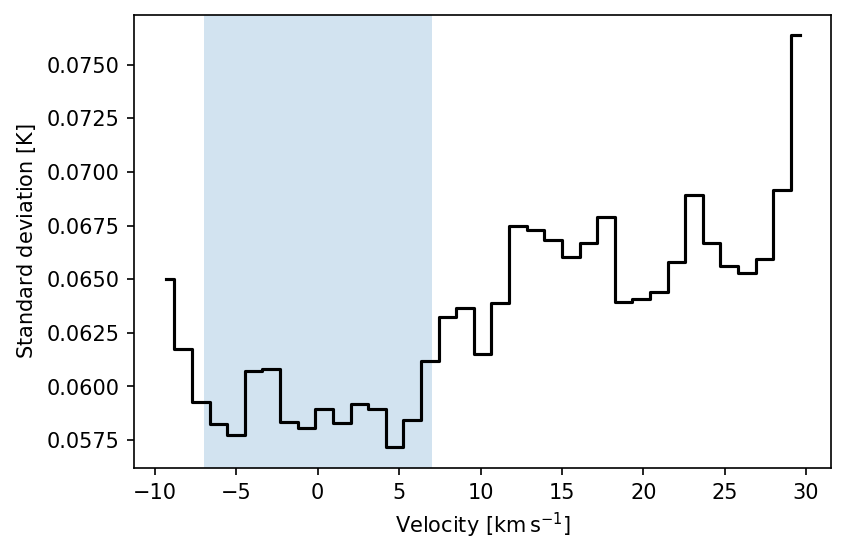

In [31]:
import matplotlib.pyplot as plt

# For rectangle:
import matplotlib.patches as mpatches
fig = plt.figure(dpi = display_dpi)
ax = fig.add_subplot(111)

# Make signal mask out of template molecule cube, in noise-free area (should be flat)
h2cs_sclip = h2cssubcube_f.sigma_clip_spectrally(3)
mad_std_spectrum_sclip = h2cs_sclip.mad_std(axis=(1, 2))

plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
         drawstyle = 'steps-mid', c = 'k')
spec_ylim = plt.gca().get_ylim()
plt.ylim(spec_ylim)
xunit = mad_std_spectrum_sclip.spectral_axis.unit.to_string('latex_inline')
yunit = mad_std_spectrum_sclip.unit.to_string('latex_inline')
plt.xlabel(f"Velocity [{xunit}]")
plt.ylabel(f"Standard deviation [{yunit}]")

rect_min = np.min(mad_std_spectrum_sclip.value) - 0.01
rect_max = np.max(mad_std_spectrum_sclip.value) + 0.01
rect_span = rect_max - rect_min
flat_noise = mpatches.Rectangle((-7, rect_min), 14, rect_span, alpha = 0.2, facecolor = "tab:blue")
plt.gca().add_patch(flat_noise)

plt.savefig("figures/flat_noise.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

The noise estimate here varies slightly as a function of velocity (though the extent of the *y*-axis is not too great), but we can try to use the spectrum between about -7 and 7 km/s (which seems marginally flatter) to estimate the noise map.

[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed | 11.3s


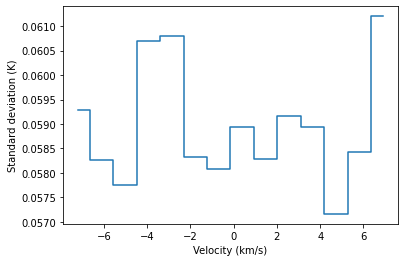

In [32]:
h2cs_sclip_cut = h2cs_sclip.spectral_slab(-7*u.km/u.s, 7*u.km/u.s)
mad_std_spectrum_sclip_cut = h2cs_sclip_cut.mad_std(axis=(1, 2))

plt.plot(mad_std_spectrum_sclip_cut.spectral_axis.value, mad_std_spectrum_sclip_cut.value, 
         drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r'Standard deviation (K)')

mad_std_map_sclip = h2cs_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension
# mad_std_map_sclip.write('temperature_map/methyl_cyanide/template_noise.fits', overwrite = True)

from astropy.io import fits
data = mad_std_map_sclip.value

header = mad_std_map_sclip.header.copy() # or copy.copy(old_header)
wcs = mad_std_map_sclip.wcs
header.update(wcs.to_header())
header['BUNIT'] = mad_std_map_sclip.unit.to_string('fits')

fits.PrimaryHDU(data=data, header=header).writeto('temperature_map/methyl_cyanide/template_noise.fits', 
                                                  overwrite = True) # Export map

We will take a quick look at the noise map to make sure it looks okay.

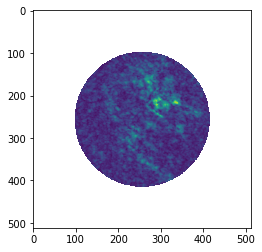

In [33]:
mad_std_map_sclip.quicklook()

Now, we'll create a "plain mask" where we mask the template cube and only keep pixels that are at or above 3 sigma (where sigma is given on a pixel-by-pixel basis by the noise map we just created).

In [34]:
plain_mask = h2cssubcube_f >= 3 * mad_std_map_sclip # Get plain 3sigma mask
plain_masked_slab = h2cssubcube_f.with_mask(plain_mask) # Mask the template molecule cube

Then, we'll apply that mask to the template molecule cube and create a more sophisticated "signal mask" from that cube, which takes into account the fact that connected regions of signal are more likely to be real than an individual high-sigma pixel.

In [35]:
import scipy.ndimage as nd

def generate_signal_mask(plain_masked_slab, mad_std_map_sclip):
    # Make a low and high mask
    low_snr_mask = (plain_masked_slab > 3 * mad_std_map_sclip).include()
    high_snr_mask = (plain_masked_slab > 10 * mad_std_map_sclip).include()
    low_snr_mask = low_snr_mask.compute() # Don't need this for this tutorial
    high_snr_mask = high_snr_mask.compute() # Don't need this for this tutorial
    # Find connected structures
    structure = np.ones((3, 3, 3), dtype=bool)
    low_snr_mask_labels, num_labels = nd.label(low_snr_mask, structure=structure)
    print(f"Initial number of regions found: {num_labels}")
    # From the labels, count the number of pixels within each label.
    num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                         labels=low_snr_mask_labels,
                                         index=range(1, num_labels + 1)) # +1 offset for mask labels
    # Repeat for the high signal mask.
    num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                        labels=low_snr_mask_labels,
                                        index=range(1, num_labels + 1)) # +1 offset for mask labels
    # To preserve the low_snr_mask, we will create a new signal mask where we will remove 
    # regions that do not pass the criteria.
    signal_mask = low_snr_mask
    low_min_pixels = 40
    high_min_pixels = 10
    for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, 
                                                          num_pixels_in_low_snr_mask)):
        if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
            # This region passes the criteria. Keep it in the mask.
            continue
        # Remove regions that do not pass the criteria.
        # NOTE: enumerate will start with 0, but the mask labels start at 1
        # We apply a +1 offset to `num` to account for this.
        signal_mask[low_snr_mask_labels == num + 1] = False
    signal_mask_labels, num_labels = nd.label(signal_mask,
                                              structure=structure)
    print(f"Final number of regions found: {num_labels}")
    signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)
    return signal_mask

In [36]:
signal_mask = generate_signal_mask(plain_masked_slab, mad_std_map_sclip)

[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  5.1s
Initial number of regions found: 1330
Final number of regions found: 5


In [37]:
print(signal_mask)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

Finally, we'll apply the signal mask we just created using the template molecule cube (which has a mask at each velocity step) to the target molecule cube.

In [38]:
masked_cube = targetsubcube_f_reproj.with_mask(signal_mask)
# We can write the masked cube to a file and look at it in DS9, but this is optional:
# masked_cube.write('masked_target_cube.fits', overwrite=True)
# masked_cube = SpectralCube.read('masked_target_cube.fits')

Let's visualize the mask.

[########################################] | 100% Completed |  0.5s


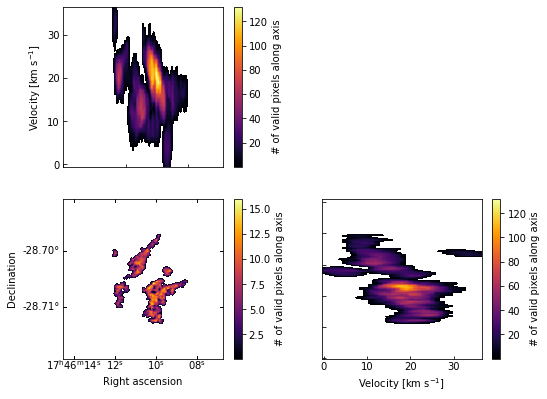

In [39]:
# Imports and matplotlib settings
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.facecolor'] = 'w'

# Collapse the mask in three dimensions
mask = signal_mask.sum(axis=0)
collapse1 = signal_mask.sum(axis = 1)
collapse2 = signal_mask.sum(axis = 2)

# Set up maximum value for colorbar
vmax = np.max([mask.max(), collapse1.max(), collapse2.max()])
norm = simple_norm(mask, stretch='linear', max_cut=vmax, min_cut=0.1)
cm = pl.matplotlib.cm.inferno.copy()
cm.set_under('w') # Make sure the "zero" color is white

fig = plt.figure(figsize = (8.5, 10)) # constrained_layout=True

# Get WCS coordinates from an (arbitrary?) masked cube
masked_moment0 = masked_cube.moment0()
wcs = masked_moment0.wcs

# Collapse along axis 0
ax1 = plt.subplot(323, projection = wcs, aspect = 1)
ax1.set_aspect(1)
im1 = ax1.imshow(mask, origin = 'lower', cmap=cm, vmin=0.1)
ax1.tick_params(direction = 'in')
ax1.coords[0].set_major_formatter('hh:mm:ss')
ax1.coords[1].set_major_formatter('d.dd')
ax1.set_xlabel('Right ascension'), ax1.set_ylabel('Declination')
cbar1 = plt.colorbar(mappable = im1, ax = ax1)
cbar1.set_label('# of valid pixels along axis')

# This may not be right:
# overlay = ax1.get_coords_overlay('galactic')
# overlay.grid(color='white', ls='dotted')
# overlay[0].set_axislabel('Galactic longitude')
# overlay[1].set_axislabel('Galactic latitude')

# Collapse along axis 1
ax2 = plt.subplot(321, sharex = ax1) # , adjustable='box'
im2 = ax2.imshow(collapse1, origin = 'lower', norm=norm, cmap=cm)
ax2.xaxis.set_tick_params(labelbottom = False) # Remove redundant tick labels
ax2.tick_params(direction = 'in')
ax2.set_aspect(collapse1.shape[1]/collapse1.shape[0])
ax2.set_ylabel('Velocity [km s$^{{-1}}$]')
cbar2 = plt.colorbar(mappable=im2, ax=ax2)
cbar2.set_label('# of valid pixels along axis')

# Collapse along axis 2
ax3 = plt.subplot(324, sharey = ax1)
im3 = ax3.imshow(collapse2.T, origin = 'lower', norm=norm, cmap=cm)
ax3.yaxis.set_tick_params(labelleft = False) # Remove redundant tick labels
ax3.tick_params(direction = 'in')
ax3.set_aspect(collapse2.shape[0]/collapse2.shape[1])
ax3.set_xlabel('Velocity [km s$^{{-1}}$]')
cbar3 = plt.colorbar(mappable=im3, ax=ax3)
cbar3.set_label('# of valid pixels along axis')

plt.savefig("figures/mask.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

## 8. Moment Maps
First, we'll create some initial moment maps of the target molecule using the cube we just masked.

[########################################] | 100% Completed |  0.2s


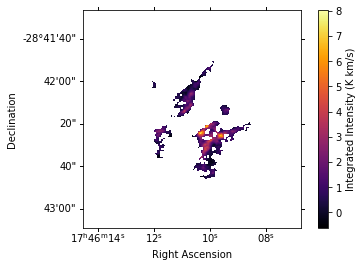

In [40]:
masked_moment0 = masked_cube.moment0()

fig = plt.figure()
ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')
plt.savefig("figures/mom0.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')

[########################################] | 100% Completed |  0.2s
[#############                           ] | 33% Completed |  0.1s

[########################################] | 100% Completed |  0.2s


<Figure size 432x288 with 0 Axes>

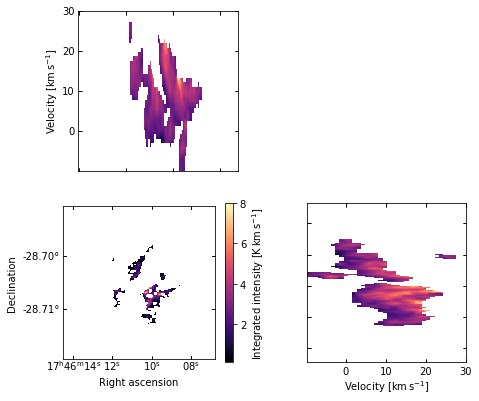

In [41]:
fig = plt.figure()
# Collapse the map in three dimensions
collapse1 = masked_cube.mean(axis = 1)
collapse2 = masked_cube.mean(axis = 2)

# Set up maximum value for colorbar
vmax = np.max(masked_moment0.max())
norm = simple_norm(masked_moment0, stretch='linear', max_cut=vmax, min_cut=0.1)
cm = pl.matplotlib.cm.magma.copy()
cm.set_under('w') # Make sure the "zero" color is white

fig = plt.figure(figsize = (7.5, 10)) # constrained_layout=True

# Get WCS coordinates
wcs = masked_moment0.wcs

# Collapse along axis 0
ax1 = plt.subplot(323, projection = wcs, aspect = 1)
ax1.set_aspect(1)
im1 = ax1.imshow(masked_moment0.value, origin = 'lower', cmap=cm, vmin=0.1)
ax1.tick_params(direction = 'in')
ax1.coords[0].set_major_formatter('hh:mm:ss')
ax1.coords[1].set_major_formatter('d.dd')
ax1.set_xlabel('Right ascension'), ax1.set_ylabel('Declination')
cbar1 = plt.colorbar(mappable = im1, ax = ax1)
cbar1.set_label(f'Integrated intensity [{masked_moment0.unit.to_string("latex_inline")}]')

# This may not be right:
# overlay = ax1.get_coords_overlay('galactic')
# overlay.grid(color='white', ls='dotted')
# overlay[0].set_axislabel('Galactic longitude')
# overlay[1].set_axislabel('Galactic latitude')

# Collapse along axis 1
ax2 = plt.subplot(321, projection = collapse1.wcs, sharex = ax1) # , adjustable='box'
im2 = ax2.imshow(collapse1.value, origin = 'lower', cmap=cm)
# ax2.xaxis.set_tick_params(labelbottom = False) # Remove redundant tick labels [doesn't work anymore?]
ax2.coords[0].set_ticklabel_visible(False)
ax2.coords[1].set_format_unit(u.km / u.s)
ax2.tick_params(direction = 'in')
ax2.set_aspect(collapse1.shape[1]/collapse1.shape[0])
ax2.set_ylabel(f'Velocity [{masked_cube.spectral_axis.unit.to_string("latex_inline")}]')

# Collapse along axis 2
ax3 = plt.subplot(324, projection = collapse2.wcs.sub([2,1]), sharey = ax1)
im3 = ax3.imshow(collapse2.T.value, origin = 'lower', cmap=cm)
# ax3.yaxis.set_tick_params(labeltop = False) # Remove redundant tick labels [doesn't work anymore?]
ax3.coords[1].set_ticklabel_visible(False)
ax3.coords[0].set_format_unit(u.km / u.s)
ax3.tick_params(direction = 'in')
ax3.set_aspect(collapse2.shape[0]/collapse2.shape[1])
ax3.set_xlabel(f'Velocity [{masked_cube.spectral_axis.unit.to_string("latex_inline")}]')
# # cbar3 = plt.colorbar(mappable=im3, ax=ax3)
# # cbar3.set_label('# of valid pixels along axis')

ax1.set_xlim(ax2.get_xlim()) # These need to be in RA/dec coordinates, but I don't think they are...
ax1.set_ylim(ax3.get_ylim())

# print(f"Moment map x limits: {ax1.get_xlim()}")
# print(f"Upper PV projection x limits: {ax2.get_xlim()}")
# print(f"Right PV projection x limits: {ax3.get_xlim()}")
# print(f"Moment map y limits: {ax1.get_ylim()}")
# print(f"Upper PV projection y limits: {ax2.get_ylim()}")
# print(f"Right PV projection y limits: {ax3.get_ylim()}")

plt.savefig("figures/mom0_PV.pdf", dpi = 300, facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


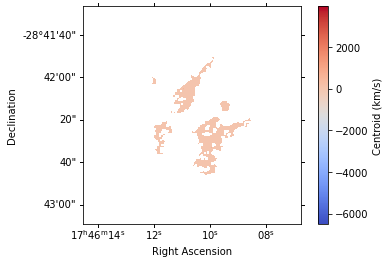

In [42]:
masked_moment1 = masked_cube.moment1()

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

The color bar on the moment 1 map is skewed due to the presence of at least one outlier pixel with a large negative velocity.

## 9. Masking Outliers
At the moment, to get a better idea of the velocity structure of the target molecule, we can mask the outliers by masking pixels with a moment 0 value less than some threshold, which can cause moment 1 values to blow up since the moment 0 value appears in the denominator of the moment 1 value.

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


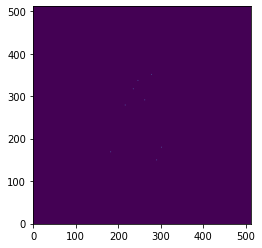

In [43]:
from pylab import imshow
v_thresh = 1000
masked_moment1 = masked_cube.moment1()
masked_moment1_outliers = (masked_moment1 > v_thresh*u.km/u.s)|(masked_moment1 < -v_thresh*u.km/u.s)
imshow(masked_moment1_outliers, origin='lower') 
# Clumps of outliers might mean they're real, just outside of vel range

We can look at a spectrum of an outlier pixel individually and check neighboring spectra.

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
-6494.197894536602 km / s


Text(0, 0.5, 'Intensity')

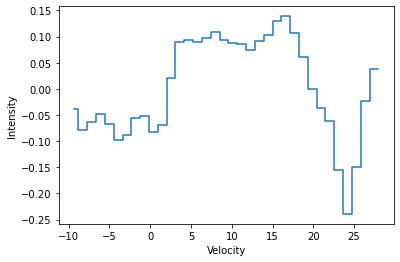

In [44]:
max_vel_coord = np.unravel_index(np.nanargmin(masked_moment1), masked_moment1.shape)
spectrum = masked_cube[:, max_vel_coord[0], max_vel_coord[1]]
print(masked_moment1[max_vel_coord[0], max_vel_coord[1]])
plt.plot(spectrum.spectral_axis, spectrum.value, drawstyle='steps-mid')
plt.xlabel('Velocity')
plt.ylabel('Intensity')

Now, we'll remove outliers by removing all pixels with moment 0 values less than a threshold value.

In [45]:
mom0 = masked_cube.moment0()
mom0_mask = mom0 > 0.3*u.K*u.km/u.s # Mask pixels with mom0 less than threshold
print(f"Found {mom0_mask.sum()} good pixels")
masked_cube_no_outliers = masked_cube.with_mask(mom0_mask)

[########################################] | 100% Completed |  0.2s
Found 11569 good pixels


Let's also export the masked cube for this rung.

In [46]:
masked_cube_no_outliers

DaskSpectralCube with shape=(37, 512, 512) and unit=K and chunk size (37, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     37  type_s: VRAD      unit_s: km / s  range:       -9.343 km / s:      29.607 km / s

In [47]:
# header

In [48]:
data = masked_cube_no_outliers # 'DaskSpectralCube' object has no attribute 'value'

header = masked_cube_no_outliers.header.copy() # or copy.copy(old_header)
wcs = masked_cube_no_outliers.wcs
header.update(wcs.to_header())
header['BUNIT'] = masked_cube_no_outliers.unit.to_string('fits')

fits.PrimaryHDU(data=data, header=header).writeto('temperature_map/methyl_cyanide/ch3cn_0_masked.fits',
                                                  overwrite = True) # Export cube

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

In [49]:
# Also export masked template molecule cube, because we need its mom1 and mom2 estimates
template_cube_masked = h2cssubcube_f.with_mask(signal_mask)

data = template_cube_masked # 'DaskSpectralCube' object has no attribute 'value'

header = template_cube_masked.header.copy() # or copy.copy(old_header)
wcs = template_cube_masked.wcs
header.update(wcs.to_header())
header['BUNIT'] = template_cube_masked.unit.to_string('fits')

fits.PrimaryHDU(data=data, header=header).writeto('temperature_map/methyl_cyanide/template_cube_masked.fits',
                                                  overwrite = True) # Export cube

[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.2s
[########################################] | 100

We'll make more final moment maps now.

[########################################] | 100% Completed |  0.3s


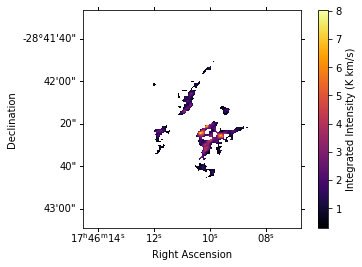

In [50]:
masked_moment0 = masked_cube_no_outliers.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


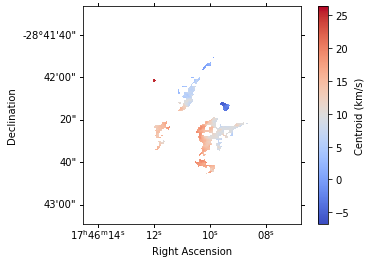

In [51]:
masked_moment1 = masked_cube_no_outliers.moment1()

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

The velocity structure is more visible here with the outliers removed.

### Addendum: collapse masked cube along spatial axes to make PV projections

In [52]:
# masked_cube_no_outliers.shape # (75, 250, 250)
# collapse1 = masked_cube_no_outliers.sum(axis = 1) # Collapse along one spatial axis
# collapse2 = masked_cube_no_outliers.sum(axis = 2) # Collapse along the other spatial axis

In [53]:
# imshow(collapse1.value, origin='lower')

In [54]:
# imshow(collapse2.value, origin='lower')

In [55]:
# Some leftover code from going over this with Adam
# Log file is located here: 
# /orange/adamginsburg/brick_alma_linesurvey/2019.1.00092.S/imaging_results/ipython_log_2021-06-21.py

# subcube_regrid.with_mask(mask, tolerance=1000)
# subcube_regrid.with_mask(mask.include())
# mask.include()
# mask = (h2cscube > 5*u.mJy/u.beam).include().compute()
# subcube_regrid.with_mask(mask)
# #subcube_regrid.with_mask(mask).write('
# get_ipython().run_line_magic('history', '')
# subcube_regrid.with_mask(mask).write('CH3CN_8(0)-7(0)_masked.fits')
# masked_subcube_regrid = subcube_regrid.with_mask(mask)
# masked_subcube_regrid.write('CH3CN_8(0)-7(0)_masked.fits', overwrite=True)
# masked_subcube_regrid
# masked_subcube_regrid.rechunk()
# masked_subcube_regrid.rechunk().write('CH3CN_8(0)-7(0)_masked.fits', overwrite=True)

# ch3cnK0 = SpectralCube.read('./thioformaldehyde/H2CS_303-202.fits')
# ch3cnK0
# ch3cnK0_rg = ch3cnK0.convolve_to(h2cscubes.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# ch3cnK0_rg.with_mask(mask)
# ch3cnK0 = SpectralCube.read('CH3CN_8(0)-7(0).fits')
# ch3cnK0_rg = ch3cnK0.convolve_to(h2cscubes.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# h2cscube
# ch3cnK0_rg = ch3cnK0.convolve_to(h2cscube.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# ch3cnK0_rg
# ch3cnK0_rg.with_mask(mask).write('CH3CN_8(0)-7(0)_masked.fits', overwrite=True)
# #cube = SpectralCube.read('../imaging_results/source_ab_137_spw69_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image')
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spect
# ral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz)
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spect
# ral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz)
# ch3cnK0_dc_rg = ch3cnK0_dask_cube.convolve_to(h2cscubes.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spect
# ral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz)
# ch3cnK0_dc_rg = ch3cnK0_dask_cube.convolve_to(h2cscube.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# # the above is very fast b/c it was lazy
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# ch3cnK0_dc_rg = ch3cnK0_dask_cube.convolve_to(h2cscube.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# # the above is very fast b/c it was lazy
# ch3cnK0_dc_rg
# ch3cnK0_dc_rg._data
# mch3cnK0_dc_rg = ch3cnK0_dc_rg.with_mask(mask)
# with ProgressBar():
#     mch3cnK0_dc_rg.write('TEST.fits')

## 10. Repeat for the other rungs
Now, we will repeat this for the rest of the CH3CN rungs.

In [56]:
# This is an attempt to re-run the notebook for all rungs except index 0. It is untested.
# for ch3cn_freq in ch3cn_freqs[1:]:
    
#     # Convert cube spectral axes from frequency to velocity
#     ch3cncube = ch3cncube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
#                                              rest_value=ch3cn_freq*u.GHz).spectral_slab(-10*u.km/u.s, 
#                                                                                         80*u.km/u.s)
#     print(ch3cncube)
#     ch3cnsubcube = ch3cncube.spectral_slab(-10*u.km/u.s, 30*u.km/u.s)
    
#     # Do some quicklooks of the peak intensity to see what we expect to see
#     ch3cnsubcube.max(axis=0).quicklook()
    
#     # Spectral interpolation
#     ch3cnsubcube_common_beam = ch3cnsubcube.beams.common_beam()
#     ch3cnsubcube_b = ch3cnsubcube.convolve_to(ch3cnsubcube_common_beam)
#     ch3cnsubcube_b = ch3cnsubcube_b.with_spectral_unit(u.km/u.s)
#     velocity_res_2 = np.diff(ch3cnsubcube_b.spectral_axis)[0]
#     fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2)**0.5
#     spectral_smoothing_kernel = Gaussian1DKernel(stddev=fwhm_gaussian.to(u.km/u.s).value / fwhm_to_sigma)
#     vel_lo = np.max([h2cssubcube_b.spectral_axis.min().value, 
#                      ch3cnsubcube_b.spectral_axis.min().value])*u.km/u.s
#     vel_hi = np.min([h2cssubcube_b.spectral_axis.max().value, 
#                      ch3cnsubcube_b.spectral_axis.max().value])*u.km/u.s
#     h2cssubcube_bc = h2cssubcube_b.spectral_slab(vel_lo, vel_hi)
#     ch3cnsubcube_bc = ch3cnsubcube_b.spectral_slab(vel_lo, vel_hi)
#     ch3cnsubcube_bc_spec = ch3cnsubcube_bc.spectral_smooth(spectral_smoothing_kernel)
#     ch3cnsubcube_bc_spec_resample = ch3cnsubcube_bc_spec.spectral_interpolate(h2cssubcube_bc.spectral_axis)

#     # Spatial smoothing
#     ## Here we assume that the H2CS beam is larger, which might not always be right?
#     common_beam = radio_beam.commonbeam.common_2beams(radio_beam.Beams(beams=[h2cssubcube_bc.beam, 
#                                                                           ch3cnsubcube_bc_spec_resample.beam]))
#     ch3cnsubcube_bc_spec_resample_spat = ch3cnsubcube_bc_spec_resample.to(u.K).convolve_to(common_beam)
    
#     # Reprojection
#     ch3cnsubcube_bc_reproj = ch3cnsubcube_bc_spec_resample_spat.reproject(h2cssubcube_bc.header)
    
#     # Continuum subtraction
#     med1 = h2cssubcube_bc.median(axis=0)  
#     h2cssubcube_f = h2cssubcube_bc - med1
#     med2 = ch3cnsubcube_bc_reproj.median(axis=0)  
#     ch3cnsubcube_f_reproj = ch3cnsubcube_bc_reproj - med2
    
#     # More to do here...

Loop code, as of February 9, 2022.

In [57]:
for comp in np.arange(1, 8, 1):
    
    print(f"#######################################")
    print(f"Repeating analysis for component {comp}")
    print(f"#######################################")
    
    ## Step 3: Cube conversions
    targetcube, targetsubcube = get_targetcube(comp) # Get target cube and vel subcube for this comp
    targetsubcube = targetsubcube.to(u.K) # Convert target subcube from Jy/beam to K
    
    ## Step 4: Spectral interpolation
    targetsubcube_common_beam = targetsubcube.beams.common_beam() # Get common beam for target cube
    targetsubcube_b = targetsubcube.convolve_to(targetsubcube_common_beam) # Smooth target cube to common beam
    targetsubcube_b = targetsubcube_b.with_spectral_unit(u.km/u.s) # Convert spectral axis to vel
    velocity_res_2 = np.diff(targetsubcube_b.spectral_axis)[0] # Get velocity resolution for target cube
    fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2)**0.5 # Generate Gaussian beam for smoothing
    spectral_smoothing_kernel = Gaussian1DKernel(stddev=fwhm_gaussian.to(u.km/u.s).value / fwhm_to_sigma) # Generate smoothing kernel
    
    # Cut cubes so they only cover a common velocity range
    vel_lo = np.max([h2cssubcube_b.spectral_axis.min().value,
                     targetsubcube_b.spectral_axis.min().value])*u.km/u.s
    vel_hi = np.min([h2cssubcube_b.spectral_axis.max().value, 
                     targetsubcube_b.spectral_axis.max().value])*u.km/u.s
    h2cssubcube_bc = h2cssubcube_b.spectral_slab(vel_lo, vel_hi) # Might be able to get around repeating this
    targetsubcube_bc = targetsubcube_b.spectral_slab(vel_lo, vel_hi)
    
    targetsubcube_bc_spec = targetsubcube_bc.spectral_smooth(spectral_smoothing_kernel) # Smooth (spectrally) target cube (assumed smaller channel width)
    targetsubcube_bc_spec_resample = targetsubcube_bc_spec.spectral_interpolate(h2cssubcube_bc.spectral_axis) # Resample target cube
    
    ## Step 5: Spatial smoothing
    common_beam = radio_beam.commonbeam.common_2beams(radio_beam.Beams(beams=[h2cssubcube_bc.beam, 
                                                                              targetsubcube_bc_spec_resample.beam])) # Calculate common beam 
    targetsubcube_bc_spec_resample_spat = targetsubcube_bc_spec_resample.to(u.K).convolve_to(common_beam) # Smooth (spatially) target cube (assumed smaller resolution)
    
    ## Step 6: Reprojection
    targetsubcube_bc_reproj = targetsubcube_bc_spec_resample_spat.reproject(h2cssubcube_bc.header) # Reproject one cube onto the other
    print('### Check to see if these two cubes have the same size spectral axes:')
    print(targetsubcube_bc_reproj) # Print these out...
    print(h2cssubcube_bc) # Print these out...
    
    # Continuum subtraction
    med1 = h2cssubcube_bc.median(axis=0) # Calculate basic continuum level (might be able to get around repeating this)
    h2cssubcube_f = h2cssubcube_bc - med1 # Basic continuum subtraction (might be able to get around repeating this)
    med2 = targetsubcube_bc_reproj.median(axis=0) # Calculate basic continuum level
    targetsubcube_f_reproj = targetsubcube_bc_reproj - med2 # Basic continuum subtraction
    
    ## Step 7: Template masking
    # Redo signal mask creation with new h2cssubcube_f:
    h2cs_sclip = h2cssubcube_f.sigma_clip_spectrally(3)
    mad_std_spectrum_sclip = h2cs_sclip.mad_std(axis=(1, 2))
    
    h2cs_sclip_cut = h2cs_sclip.spectral_slab(-7*u.km/u.s, 7*u.km/u.s)
    mad_std_spectrum_sclip_cut = h2cs_sclip_cut.mad_std(axis=(1, 2))
    
    mad_std_map_sclip = h2cs_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension
    # I am not saving mad_std_map_sclip in this loop, just in the tutorial... though they won't be the same
    
    plain_mask = h2cssubcube_f >= 3 * mad_std_map_sclip # Get plain 3sigma mask
    plain_masked_slab = h2cssubcube_f.with_mask(plain_mask) # Mask the template molecule cube
    
    signal_mask = generate_signal_mask(plain_masked_slab, mad_std_map_sclip)
    
    masked_cube = targetsubcube_f_reproj.with_mask(signal_mask) # Apply mask to target
    
    ## Step 9: Masking outliers
    mom0 = masked_cube.moment0() # Generate moment 0 map
    mom0_mask = mom0 > 0.3*u.K*u.km/u.s # Mask pixels with mom0 less than threshold
    masked_cube_no_outliers = masked_cube.with_mask(mom0_mask) # Only keep pixels with high mom0 values

#     masked_cube_no_outliers.write(f'temperature_map/methyl_cyanide/ch3cn_{comp}_masked.fits', overwrite = True) # Export cube

    data = masked_cube_no_outliers

    header = masked_cube_no_outliers.header.copy() # or copy.copy(old_header)
    wcs = masked_cube_no_outliers.wcs
    header.update(wcs.to_header())
    header['BUNIT'] = masked_cube_no_outliers.unit.to_string('fits')
    header['RESTFRQ'] = ch3cn_freqs[comp].to(u.Hz).value

    fits.PrimaryHDU(data=data, header=header).writeto(f'temperature_map/methyl_cyanide/ch3cn_{comp}_masked.fits', 
                                                      overwrite = True) # Export cube
    
print("******COMPLETED ALL COMPONENTS SUCCESSFULLY: GOOD JOB!!!******")

#######################################
Repeating analysis for component 1
#######################################
DaskVaryingResolutionSpectralCube with shape=(92, 512, 512) and unit=Jy / beam and chunk size (66, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     92  type_s: VRAD      unit_s: km / s  range:      -10.455 km / s:      80.060 km / s
[                                        ] | 0% Completed |  0.0s

[                                        ] | 0% Completed |  3.3s

[                                        ] | 0% Completed |  7.3s

[                                        ] | 0% Completed | 28.1s

[########################################] | 100% Completed | 29.9s
### Check to see if these two cubes have the same size spectral axes:
DaskSpectralCube with shape=(38, 512, 512) and unit=K and chunk size (38, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     38  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      29.607 km / s
DaskSpectralCube with shape=(38, 512, 512) and unit=K and chunk size (38, 512, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     38  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      29.607 km / s
[########################################] | 100% Completed |  3.5s
[####################                    ] | 50% Completed |  0.1s

[########################################] | 100% Completed |  1.0s
[                                        ] | 0% Completed |  0.1s

[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.9s
Initial number of regions found: 1270
Final number of regions found: 6
[########################################] | 100% Completed |  0.4s


AttributeError: 'numpy.float64' object has no attribute 'to'